# 学习率调度器
:label:`sec_scheduler`

到目前为止，我们主要关注如何更新权重向量的优化算法，而不是它们的更新速率。
然而，调整学习率通常与实际算法同样重要，有如下几方面需要考虑：

* 首先，学习率的大小很重要。如果它太大，优化就会发散；如果它太小，训练就会需要过长时间，或者我们最终只能得到次优的结果。我们之前看到问题的条件数很重要（有关详细信息，请参见 :numref:`sec_momentum`）。直观地说，这是最不敏感与最敏感方向的变化量的比率。
* 其次，衰减速率同样很重要。如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。 :numref:`sec_minibatch_sgd`比较详细地讨论了这一点，在 :numref:`sec_sgd`中我们则分析了性能保证。简而言之，我们希望速率衰减，但要比$\mathcal{O}(t^{-\frac{1}{2}})$慢，这样能成为解决凸问题的不错选择。
* 另一个同样重要的方面是初始化。这既涉及参数最初的设置方式（详情请参阅 :numref:`sec_numerical_stability`），又关系到它们最初的演变方式。这被戏称为*预热*（warmup），即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向可能也是毫无意义的。
* 最后，还有许多优化变体可以执行周期性学习率调整。这超出了本章的范围，我们建议读者阅读 :cite:`Izmailov.Podoprikhin.Garipov.ea.2018`来了解个中细节。例如，如何通过对整个路径参数求平均值来获得更好的解。

鉴于管理学习率需要很多细节，因此大多数深度学习框架都有自动应对这个问题的工具。
在本章中，我们将梳理不同的调度策略对准确性的影响，并展示如何通过*学习率调度器*（learning rate scheduler）来有效管理。

## 一个简单的问题

我们从一个简单的问题开始，这个问题可以轻松计算，但足以说明要义。
为此，我们选择了一个稍微现代化的LeNet版本（激活函数使用`relu`而不是`sigmoid`，汇聚层使用最大汇聚层而不是平均汇聚层），并应用于Fashion-MNIST数据集。
此外，我们混合网络以提高性能。
由于大多数代码都是标准的，我们只介绍基础知识，而不做进一步的详细讨论。如果需要，请参阅 :numref:`chap_cnn`进行复习。


In [3]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [6]:
from IPython import display

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
# from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = try_gpu()

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与d2l.train_ch6定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = Accumulator(3)  # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

让我们来看看如果使用默认设置，调用此算法会发生什么。
例如设学习率为$0.3$并训练$30$次迭代。
留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。
两条曲线之间的间隙表示过拟合。


train loss 0.169, train acc 0.935, test acc 0.896


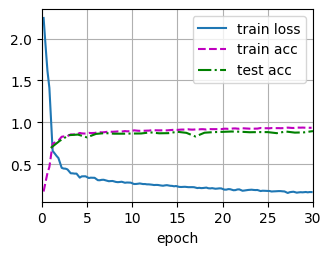

In [8]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 学习率调度器

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。
例如，以动态的方式来响应优化的进展情况。


In [9]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


更通常而言，我们应该定义一个调度器。
当调用更新次数时，它将返回学习率的适当值。
让我们定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [10]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

让我们在一系列值上绘制它的行为。


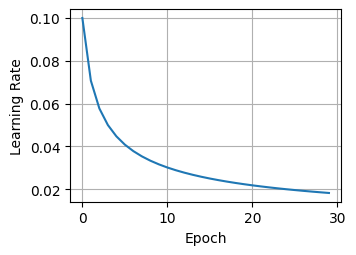

In [11]:
import torch
import matplotlib.pyplot as plt

scheduler = SquareRootScheduler(lr=0.1)
# d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

# 设置参数
num_epochs = 30

# 计算每个时间点的学习率
epochs = torch.arange(num_epochs)
learning_rates = [scheduler(t) for t in range(num_epochs)]

# 使用 matplotlib 绘制图像
plt.figure(figsize=(3.5, 2.5))
plt.plot(epochs, learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。
我们只是提供调度器作为训练算法的额外参数。


train loss 0.283, train acc 0.897, test acc 0.882


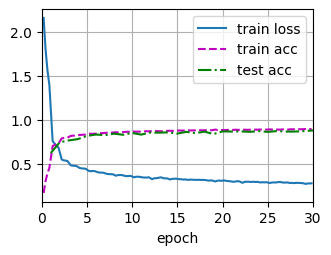

In [12]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

这比以前好一些：曲线比以前更加平滑，并且过拟合更小了。
遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，较小的步长将导致参数更接近零，因此更简单。
但是，这并不能完全解释这种现象，因为我们并没有真正地提前停止，而只是轻柔地降低了学习率。

## 策略

虽然我们不可能涵盖所有类型的学习率调度器，但我们会尝试在下面简要概述常用的策略：多项式衰减和分段常数表。
此外，余弦学习率调度在实践中的一些问题上运行效果很好。
在某些问题上，最好在使用较高的学习率之前预热优化器。

### 单因子调度器

多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。
为了防止学习率衰减到一个合理的下界之下，
更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。


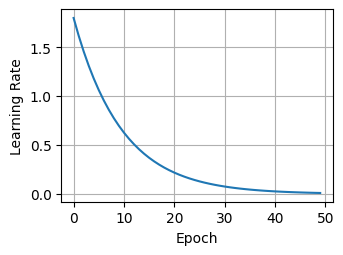

In [13]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
# d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

# 计算学习率序列
epochs = torch.arange(50)
learning_rates = [scheduler(t) for t in range(50)]

# 使用 matplotlib 绘制图像，替代 d2l.plot
plt.figure(figsize=(3.5, 2.5))
plt.plot(epochs, learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

接下来，我们将使用内置的调度器，但在这里仅解释它们的功能。

### 多因子调度器

训练深度网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。
具体地说，给定一组降低学习率的时间点，例如$s = \{5, 10, 20\}$，
每当$t \in s$时，降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
假设每步中的值减半，我们可以按如下方式实现这一点。


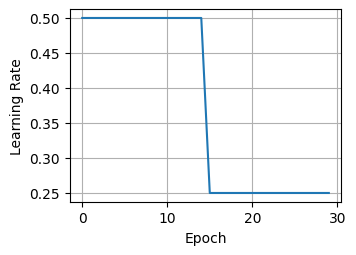

In [15]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

# d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
#                                   for t in range(num_epochs)])

# 计算每个epoch的学习率
epochs = torch.arange(num_epochs)
learning_rates = []

# 计算学习率序列
for t in range(num_epochs):
    current_lr = scheduler.get_last_lr()[0]
    learning_rates.append(current_lr)
    # 模拟一步优化步骤
    trainer.step()
    scheduler.step()

# 使用 matplotlib 绘制图像，替代 d2l.plot
plt.figure(figsize=(3.5, 2.5))
plt.plot(epochs, learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。
此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。
下面的例子展示了如何使用这种方法产生更好的解决方案。


train loss 0.200, train acc 0.925, test acc 0.890


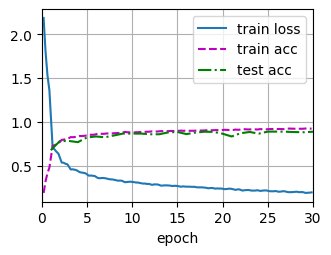

In [16]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 余弦调度器

余弦调度器是 :cite:`Loshchilov.Hutter.2016`提出的一种启发式算法。
它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。
这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在$t \in [0, T]$之间。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。
此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。
在下面的示例中，我们设置了最大更新步数$T = 20$。


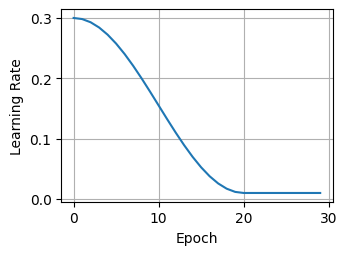

In [17]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
# d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

# 设置参数
num_epochs = 30

# 计算学习率序列
epochs = torch.arange(num_epochs)
learning_rates = [scheduler(t) for t in range(num_epochs)]

# 使用 matplotlib 绘制图像，替代 d2l.plot
plt.figure(figsize=(3.5, 2.5))
plt.plot(epochs, learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

在计算机视觉的背景下，这个调度方式可能产生改进的结果。
但请注意，如下所示，这种改进并不一定成立。


train loss 0.207, train acc 0.923, test acc 0.892


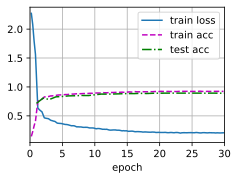

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 预热

在某些情况下，初始化参数不足以得到良好的解。
这对某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。
对此，一方面，我们可以选择一个足够小的学习率，
从而防止一开始发散，然而这样进展太缓慢。
另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。
为了简单起见，通常使用线性递增。
这引出了如下表所示的时间表。


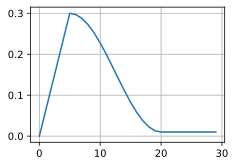

In [12]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。


train loss 0.261, train acc 0.904, test acc 0.878


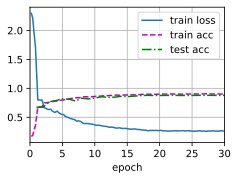

In [13]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

预热可以应用于任何调度器，而不仅仅是余弦。
有关学习率调度的更多实验和更详细讨论，请参阅 :cite:`Gotmare.Keskar.Xiong.ea.2018`。
其中，这篇论文的点睛之笔的发现：预热阶段限制了非常深的网络中参数的发散程度 。
这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散。

## 小结

* 在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。
* 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。
* 余弦调度器在某些计算机视觉问题中很受欢迎。
* 优化之前的预热期可以防止发散。
* 优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。

## 练习

1. 试验给定固定学习率的优化行为。这种情况下可以获得的最佳模型是什么？
1. 如果改变学习率下降的指数，收敛性会如何改变？在实验中方便起见，使用`PolyScheduler`。
1. 将余弦调度器应用于大型计算机视觉问题，例如训练ImageNet数据集。与其他调度器相比，它如何影响性能？
1. 预热应该持续多长时间？
1. 可以试着把优化和采样联系起来吗？首先，在随机梯度朗之万动力学上使用 :cite:`Welling.Teh.2011`的结果。


[Discussions](https://discuss.d2l.ai/t/4334)
